In [1]:
# Mount google drive
#from google.colab import drive
#drive.mount('/content/drive')

#updated yet?

In [2]:
# Import pandas, numpy and seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql

from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns',None)


In [3]:
# Define the path to the SQLite database file

#Roberto file path to DB
#db_path = 'C:/Users/rober/SQLite/CyberSentryDB.db'

#Andres file path to DB
db_path = 'C:/Users/andre/SQLite/CyberSentryDB.db'

# Establish a connection to the database specified by db_path
conn = sql.connect(db_path)

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Execute a SQL query to select all records from the 'network_activity' table
# and store the result in a pandas DataFrame 'df' for further analysis
#df = pd.read_sql_query("SELECT * FROM network_activity", conn)
df_test = pd.read_sql_query("SELECT * FROM testing_data", conn)
df_train = pd.read_sql_query("SELECT * FROM training_data", conn)

# Close the cursor to release database resources
cursor.close()

# Close the connection to the database to ensure data integrity and release resources
conn.close()


In [4]:
df_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,150,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.0,0.6,0.88,0.0,0.0,0.0,0.0,0.0,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.1,0.05,0.0,0.0,1.0,1.0,0.0,0.0,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.0,0.0,0.0,30,255,1.0,0.0,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.0,0.0,0.09,255,255,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal,21


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   duration                     125973 non-null  object
 1   protocol_type                125973 non-null  object
 2   service                      125973 non-null  object
 3   flag                         125973 non-null  object
 4   src_bytes                    125973 non-null  object
 5   dst_bytes                    125973 non-null  object
 6   land                         125973 non-null  object
 7   wrong_fragment               125973 non-null  object
 8   urgent                       125973 non-null  object
 9   hot                          125973 non-null  object
 10  num_failed_logins            125973 non-null  object
 11  logged_in                    125973 non-null  object
 12  num_compromised              125973 non-null  object
 13  root_shell    

In [6]:
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.0,1.0,1.0,0.04,0.06,0.0,255,10,0.04,0.06,0.0,0.0,0.0,0.0,1.0,1.0,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.0,1.0,1.0,0.01,0.06,0.0,255,1,0.0,0.06,0.0,0.0,0.0,0.0,1.0,1.0,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.0,0.0,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3,57,1.0,0.0,1.0,0.28,0.0,0.0,0.0,0.0,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.0,0.0,0.75,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   duration                     22544 non-null  object
 1   protocol_type                22544 non-null  object
 2   service                      22544 non-null  object
 3   flag                         22544 non-null  object
 4   src_bytes                    22544 non-null  object
 5   dst_bytes                    22544 non-null  object
 6   land                         22544 non-null  object
 7   wrong_fragment               22544 non-null  object
 8   urgent                       22544 non-null  object
 9   hot                          22544 non-null  object
 10  num_failed_logins            22544 non-null  object
 11  logged_in                    22544 non-null  object
 12  num_compromised              22544 non-null  object
 13  root_shell                   22

In [8]:
# Concatenate dataframes
df_all = pd.concat([df_train, df_test], ignore_index=True)

# Optionally, if you want to drop the old index and not add it as a column
df_all = df_all.reset_index(drop=True)

df_all.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,150,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.0,0.6,0.88,0.0,0.0,0.0,0.0,0.0,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.1,0.05,0.0,0.0,1.0,1.0,0.0,0.0,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.0,0.0,0.0,30,255,1.0,0.0,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.0,0.0,0.09,255,255,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal,21


In [9]:
# For the training dataset:
# Keep rows with 'outcome' as 'normal' unchanged.
df_train.loc[df_train['outcome'] == "normal", "outcome"] = 'normal'  
# Change 'outcome' values not equal to 'normal' to 'attack' in the training dataset.
df_train.loc[df_train['outcome'] != 'normal', "outcome"] = 'attack'

# For the testing dataset:
# Keep rows with 'outcome' as 'normal' unchanged.
df_test.loc[df_test['outcome'] == "normal", "outcome"] = 'normal'
# Change 'outcome' values not equal to 'normal' to 'attack' in the testing dataset.
df_test.loc[df_test['outcome'] != 'normal', "outcome"] = 'attack'


In [10]:
df_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,150,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.0,0.6,0.88,0.0,0.0,0.0,0.0,0.0,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.1,0.05,0.0,0.0,1.0,1.0,0.0,0.0,attack,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.0,0.0,0.0,30,255,1.0,0.0,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.0,0.0,0.09,255,255,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal,21


In [11]:
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.0,1.0,1.0,0.04,0.06,0.0,255,10,0.04,0.06,0.0,0.0,0.0,0.0,1.0,1.0,attack,21
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.0,1.0,1.0,0.01,0.06,0.0,255,1,0.0,0.06,0.0,0.0,0.0,0.0,1.0,1.0,attack,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.0,0.0,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3,57,1.0,0.0,1.0,0.28,0.0,0.0,0.0,0.0,attack,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.0,0.0,0.75,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,attack,11


In [12]:
# Displaying the DataFrame information:
# The df_all.info() method is used to print a concise summary of the DataFrame df_all.
# This summary includes the number of non-null entries for each column, the column data type,
# and the memory usage. It's helpful for getting a quick overview of the DataFrame's structure,
# identifying missing values, and understanding the data types of each column.
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148517 entries, 0 to 148516
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   duration                     148517 non-null  object
 1   protocol_type                148517 non-null  object
 2   service                      148517 non-null  object
 3   flag                         148517 non-null  object
 4   src_bytes                    148517 non-null  object
 5   dst_bytes                    148517 non-null  object
 6   land                         148517 non-null  object
 7   wrong_fragment               148517 non-null  object
 8   urgent                       148517 non-null  object
 9   hot                          148517 non-null  object
 10  num_failed_logins            148517 non-null  object
 11  logged_in                    148517 non-null  object
 12  num_compromised              148517 non-null  object
 13  root_shell    

In [13]:
def bar_plot(df, cols_list, rows, cols):
    # Create a grid of subplots with the specified number of rows and columns.
    fig, axes = plt.subplots(rows, cols, figsize=(20, 7))
    fig.tight_layout(pad=1.0)  # Add spacing between plots for clarity

    # Flatten the axes array and iterate over it along with the column names in cols_list.
    for ax, col in zip(axes.ravel(), cols_list):
        # Use Seaborn's countplot to create a bar chart.
        sns.countplot(x=col, data=df, ax=ax)

        # Calculate the total number of data points for the percentage calculation.
        total = len(df[col])

        # Iterate through the patches (bars) in the barplot to get their properties.
        for p in ax.patches:
            # Calculate the percentage and format it.
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            # Get the x and y coordinates to place the text.
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            # Place the text on the bar.
            ax.text(x, y, percentage, ha='center', va='bottom')

        # Set the title of the current subplot to the name of the column.
        ax.set_title(str(col), fontsize=12)

        # Rotate the x-axis labels for better readability.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Adjust the layout and display the figure with all the bar charts.
    plt.tight_layout()
    plt.show()


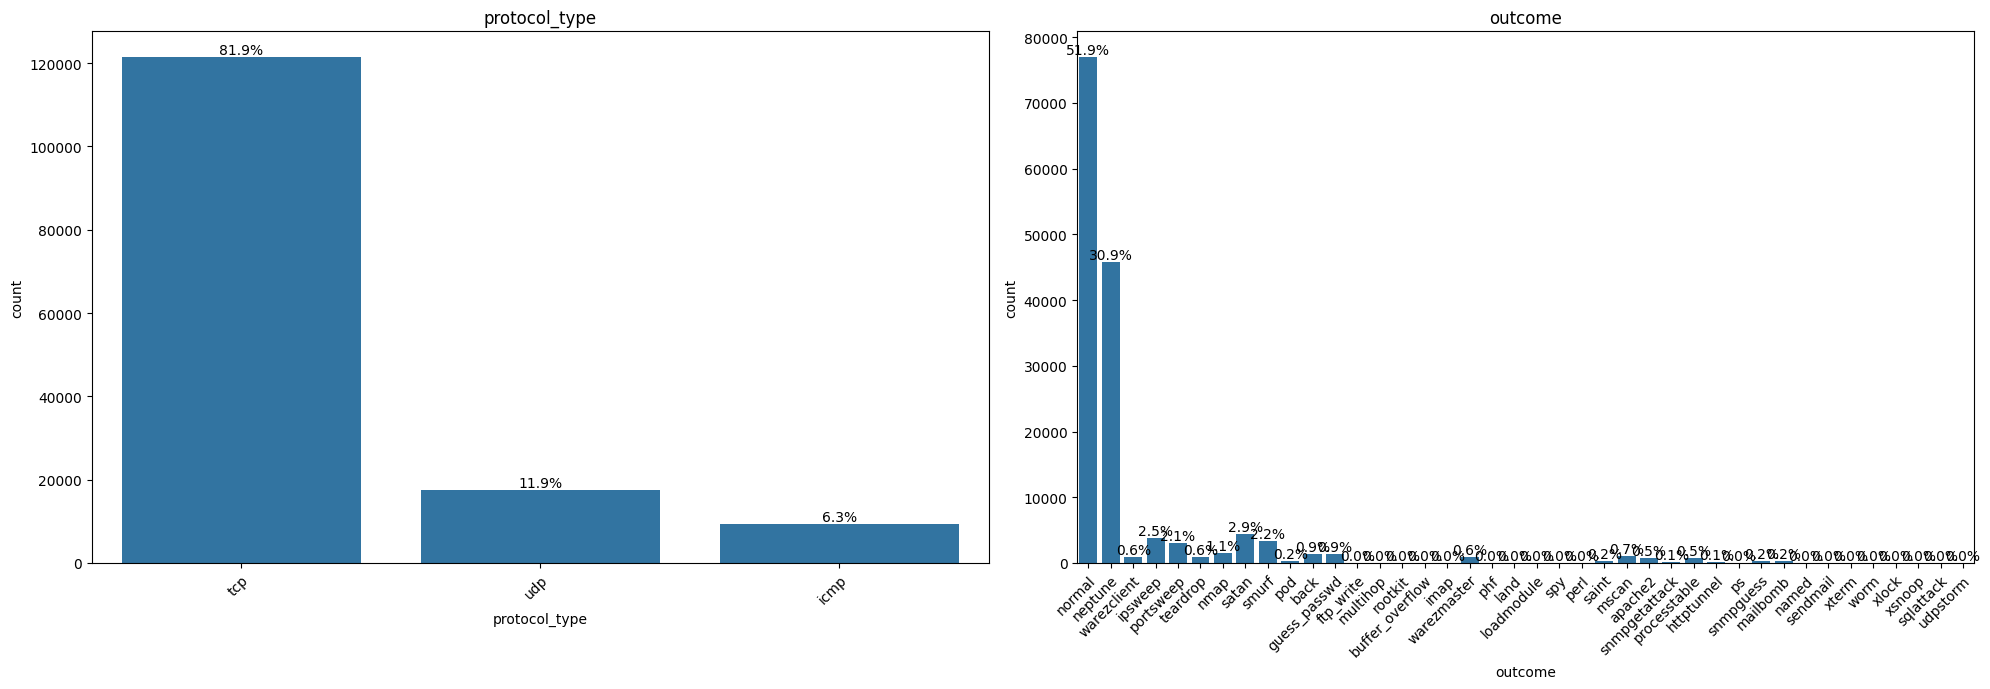

In [14]:
bar_plot(df_all, ['protocol_type', 'outcome'],1,2)

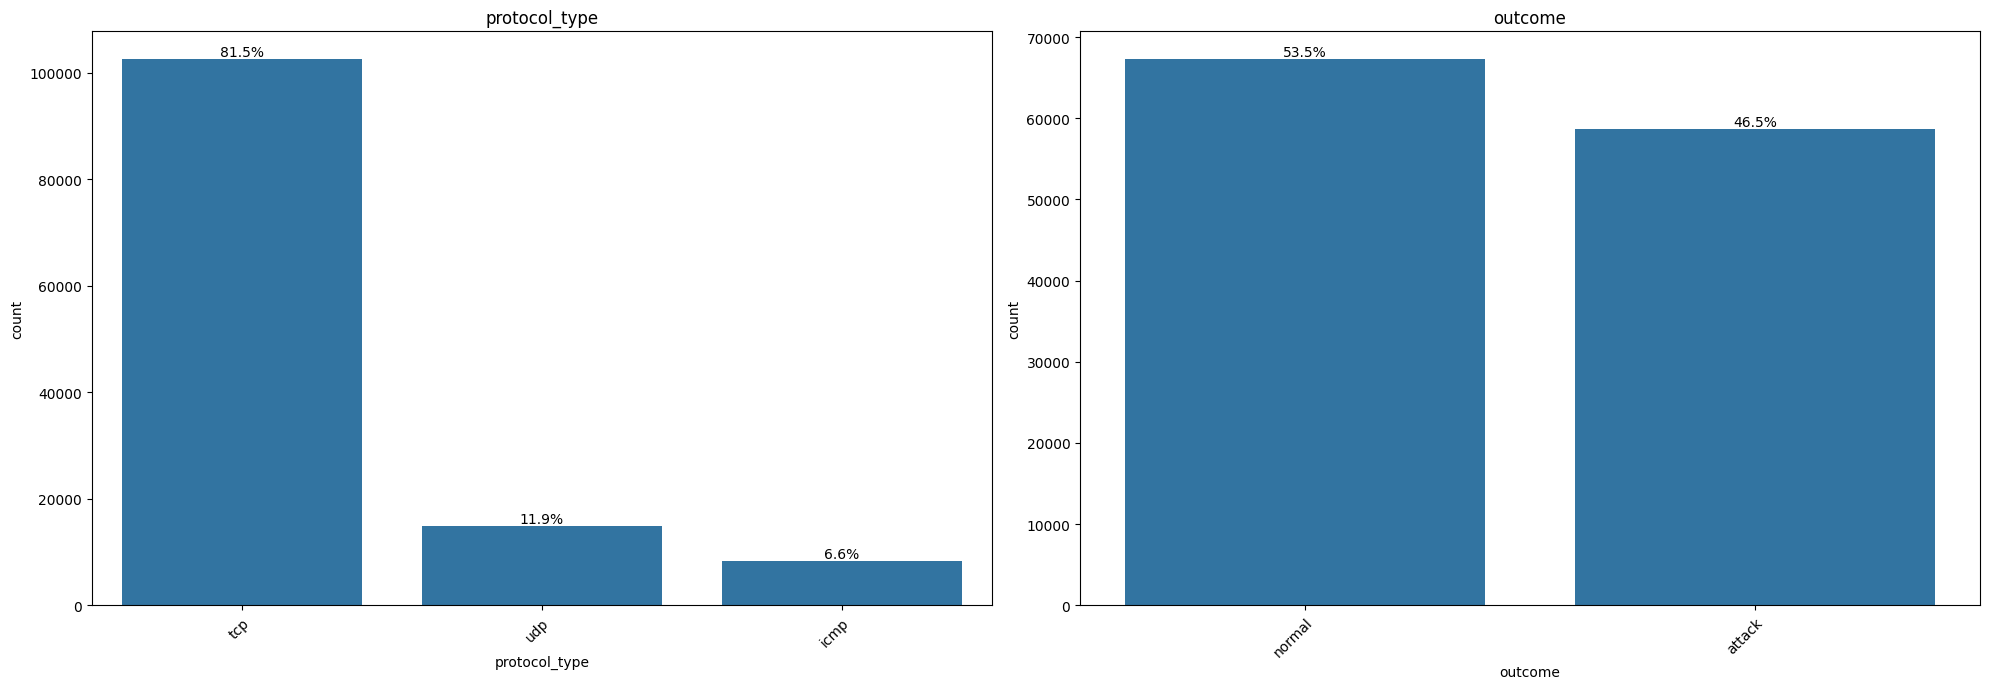

In [15]:
bar_plot(df_train, ['protocol_type', 'outcome'],1,2)

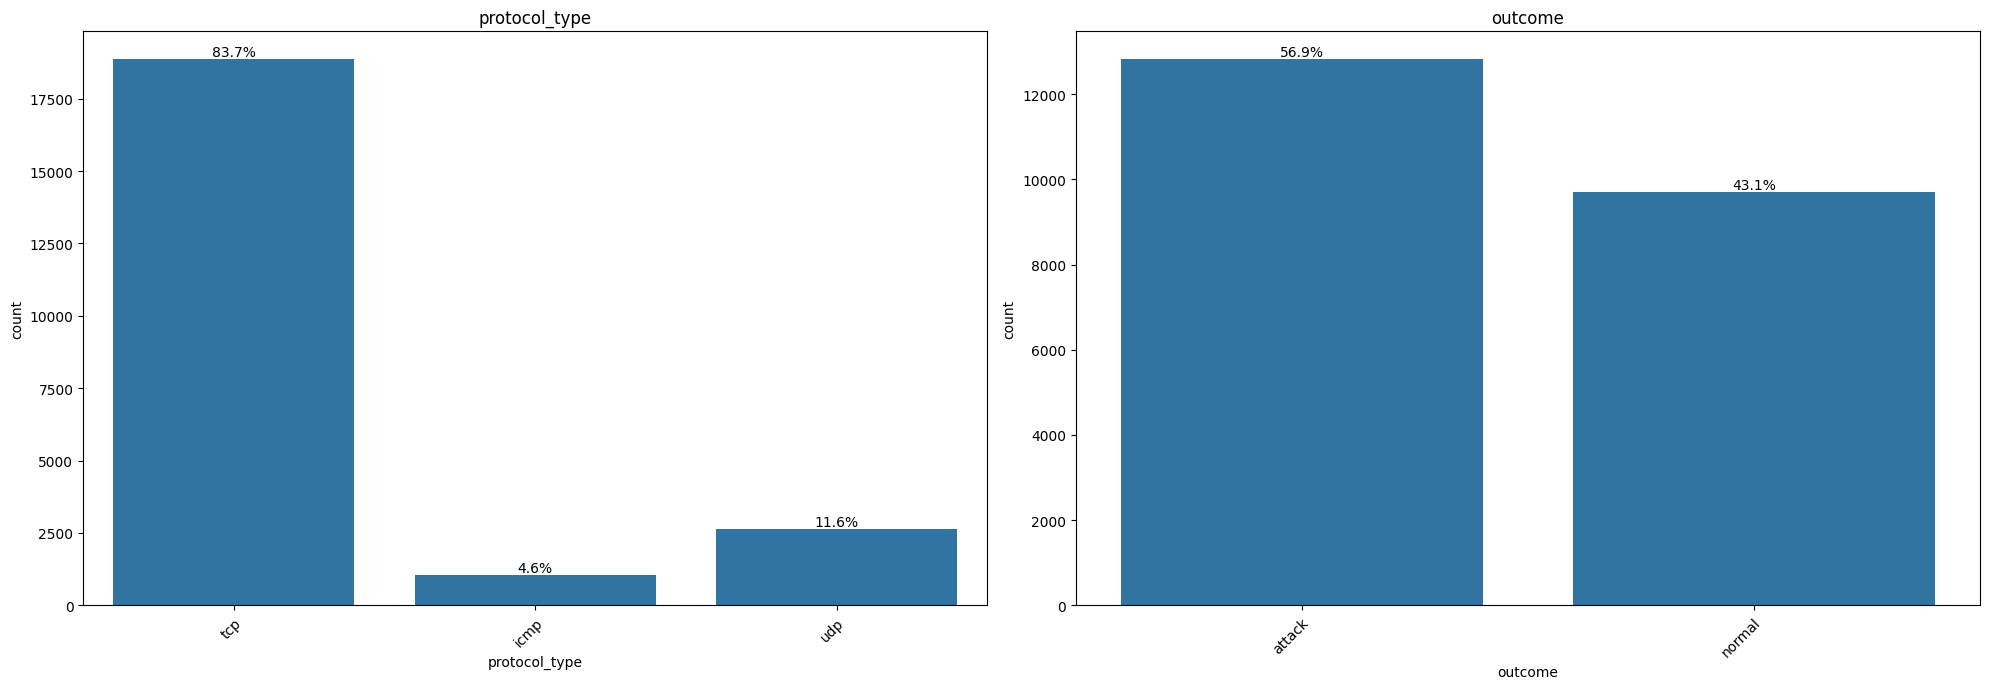

In [16]:
bar_plot(df_test, ['protocol_type', 'outcome'],1,2)

In [17]:
def pie_plot(df, cols_list, rows, cols):
    # Create a grid of subplots with the specified number of rows and columns.
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    fig.tight_layout(pad=1.0)  # Add spacing between plots for clarity

    # If there is only one row or one column, axes is a 1D numpy array.
    if rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.ravel()  # Flatten the axes array for iteration

    # Iterate over the axes array and the column names in cols_list.
    for ax, col in zip(axes, cols_list):
        # Calculate the value counts for the current column.
        counts = df[col].value_counts()

        # Create a pie chart in each subplot.
        ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)

        # Set the title of the current subplot to the name of the column.
        ax.set_title(str(col), fontsize=12)

    # Adjust the layout and display the figure with all the pie charts.
    plt.tight_layout()
    plt.show()

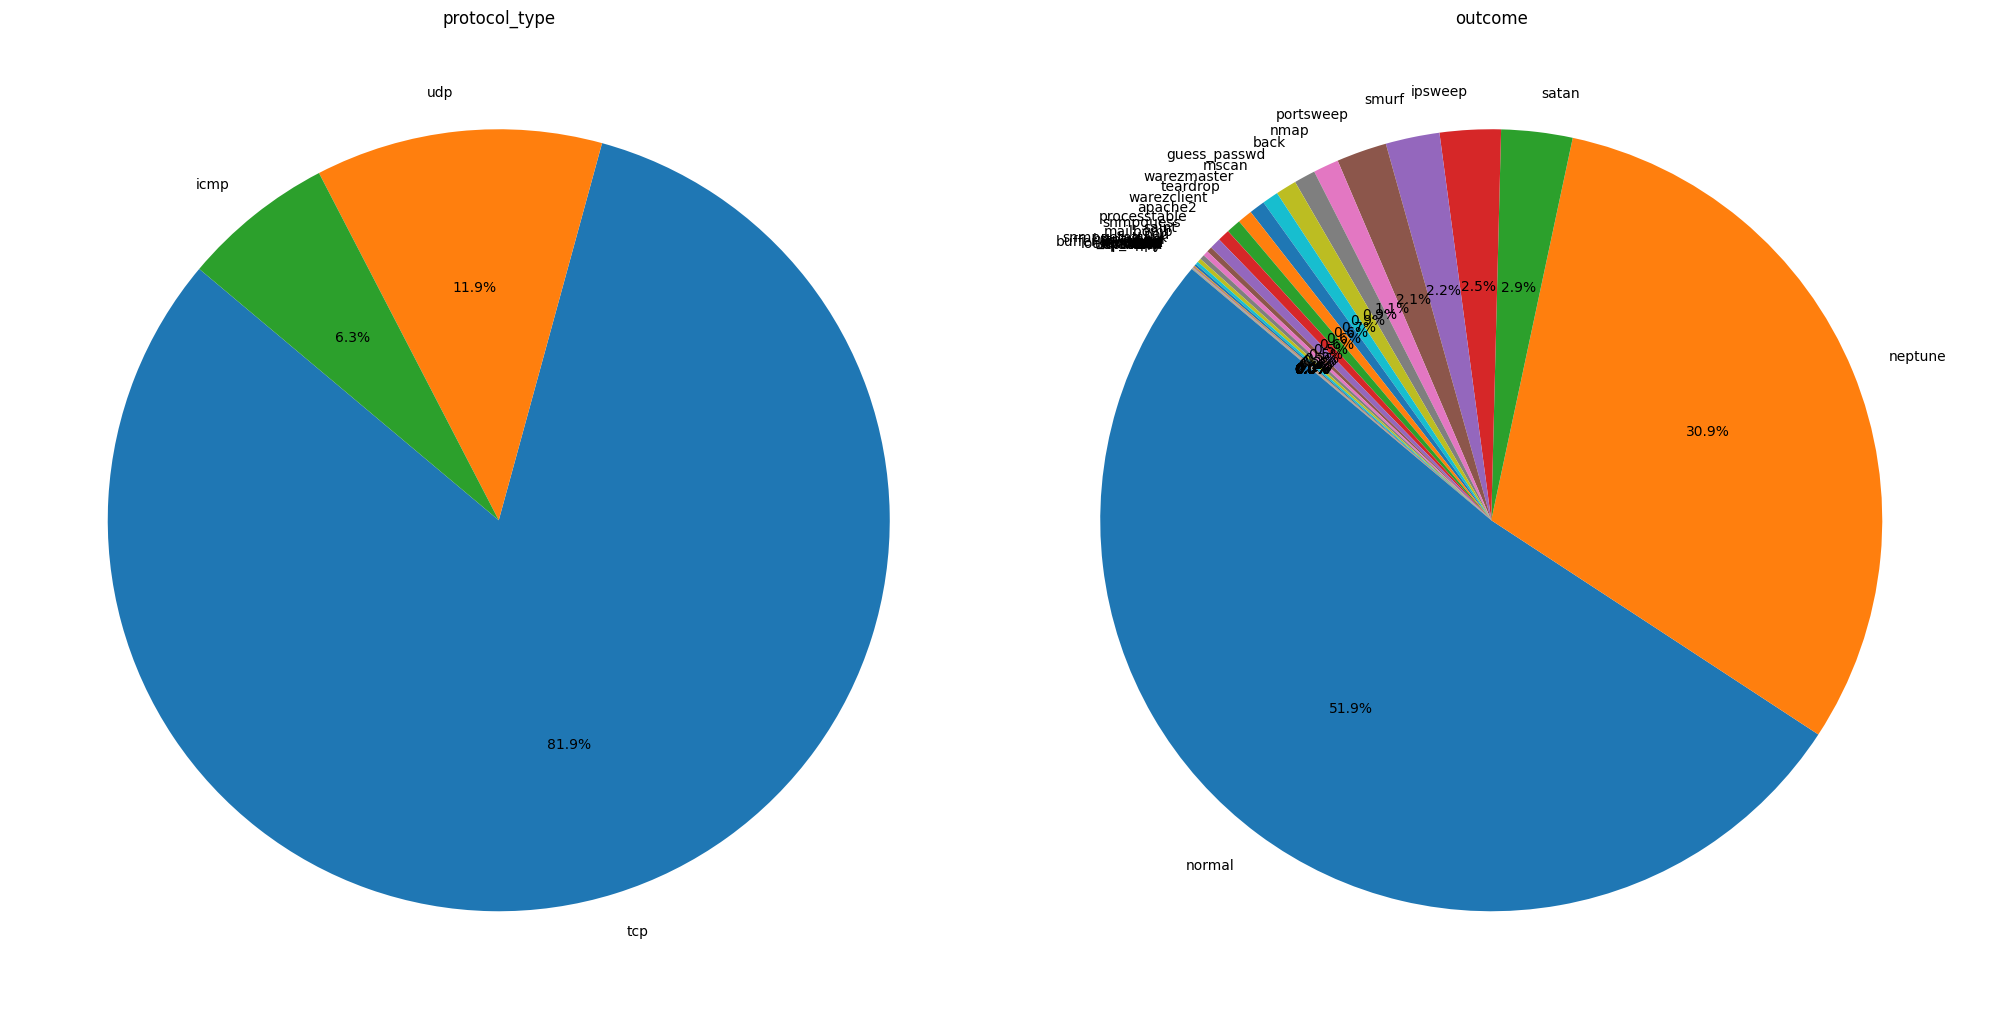

In [18]:
pie_plot(df_all, ['protocol_type','outcome'], 1, 2)

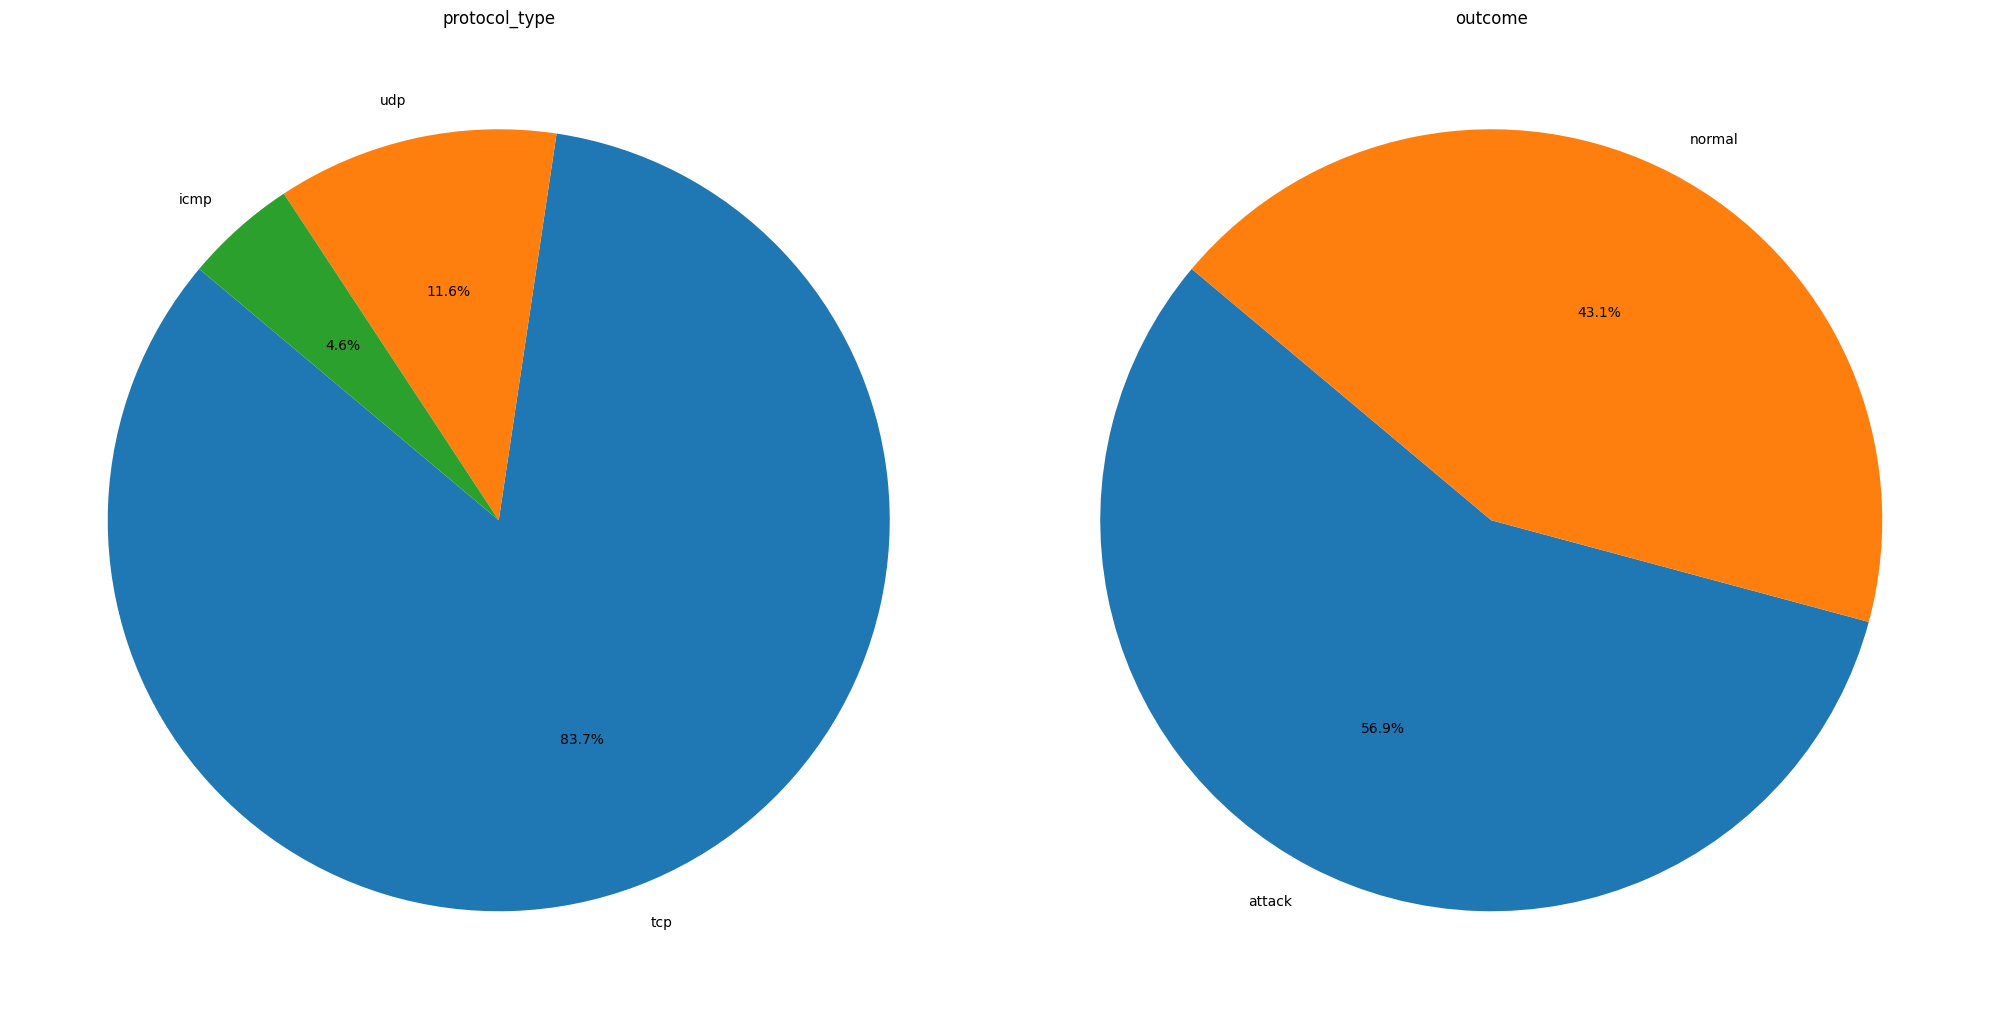

In [19]:
pie_plot(df_test, ['protocol_type','outcome'], 1, 2)

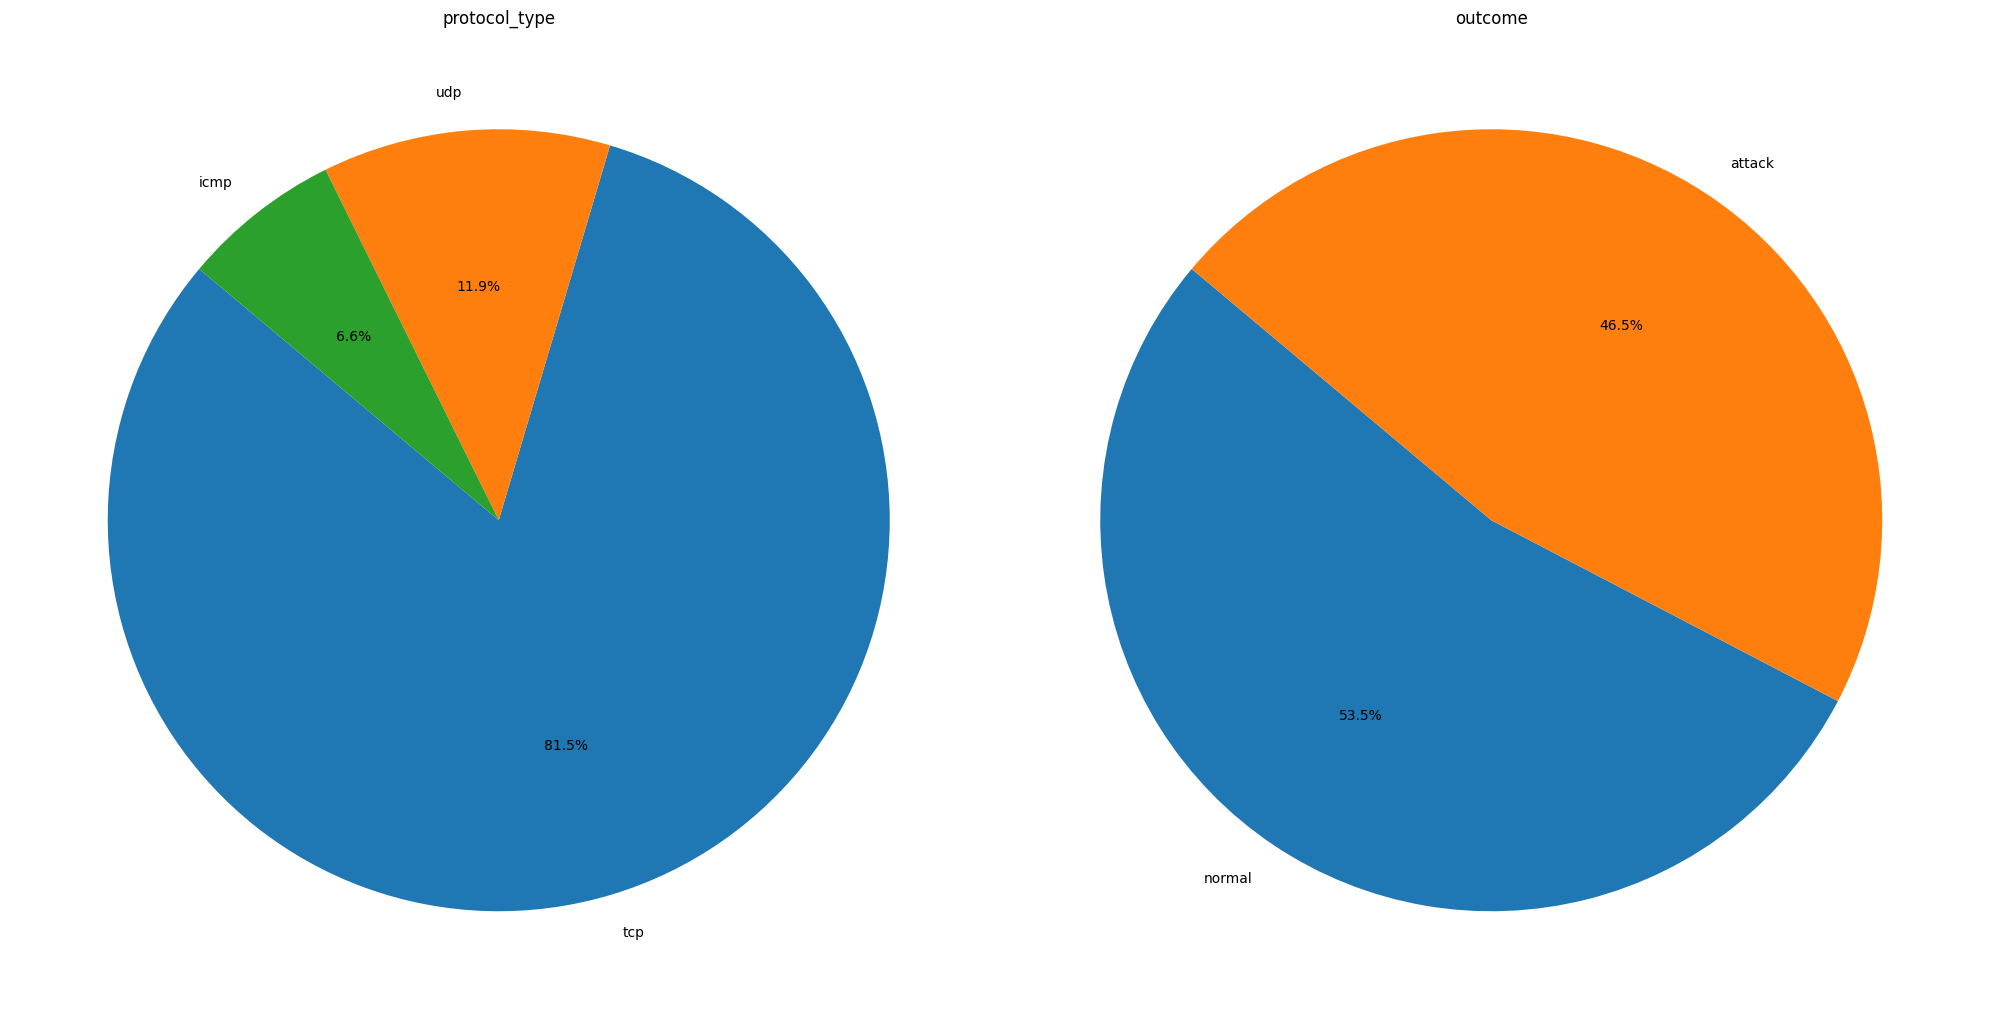

In [20]:
pie_plot(df_train, ['protocol_type','outcome'], 1, 2)

------------------------------

# **4. Preprocessing the Data**

## 4.1. Scaling the Data

In [21]:
def preprocess(dataframe, scaler=None):
    # Define categorical and numerical columns
    cat_cols = ['is_host_login', 'protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_guest_login', 'level', 'outcome']
    num_cols = dataframe.drop(columns=cat_cols).columns

    # Scale numerical columns if scaler is not provided
    if not scaler:
        scaler = StandardScaler()  # Initialize StandardScaler if not provided
    dataframe[num_cols] = scaler.fit_transform(dataframe[num_cols])  # Fit and transform numerical columns using scaler

    # Encode 'outcome' as binary (0 for 'normal', 1 for other values)
    dataframe.loc[dataframe['outcome'] == "normal", "outcome"] = 0
    dataframe.loc[dataframe['outcome'] != 0, "outcome"] = 1

    # Encode categorical columns as dummy variables
    dataframe = pd.get_dummies(dataframe, columns=['protocol_type', 'service', 'flag'])

    return dataframe, scaler  # Return preprocessed DataFrame and scaler


In [22]:
# Fit and transform the training data
df_test_scaled, scaler = preprocess(df_test)

df_train_scaled, scalar = preprocess(df_train)

In [23]:
df_test_scaled.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-0.155534,-0.021988,-0.096896,0,-0.059104,-0.019459,-0.113521,-0.143999,0,-0.016494,-0.049453,-0.012638,-0.014259,-0.012911,-0.02402,-0.052318,0.0,0,0,1.166764,-0.237191,-0.348468,-0.347390,1.830141,1.837604,-1.697859,-0.131492,-0.386963,0.650093,-1.169697,-1.305370,-0.138370,-0.431856,-0.229980,-0.358118,-0.35275,1.979791,1.929116,1,21,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
1,-0.155534,-0.021988,-0.096896,0,-0.059104,-0.019459,-0.113521,-0.143999,0,-0.016494,-0.049453,-0.012638,-0.014259,-0.012911,-0.02402,-0.052318,0.0,0,0,0.443234,-0.338246,-0.348468,-0.347390,1.830141,1.837604,-1.770589,-0.131492,-0.386963,0.650093,-1.250212,-1.397181,-0.138370,-0.431856,-0.229980,-0.358118,-0.35275,1.979791,1.929116,1,21,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
2,-0.154113,0.005473,-0.096896,0,-0.059104,-0.019459,-0.113521,-0.143999,0,-0.016494,-0.049453,-0.012638,-0.014259,-0.012911,-0.02402,-0.052318,0.0,0,0,-0.607053,-0.338246,-0.348468,-0.347390,-0.573079,-0.565054,0.629488,-0.363035,-0.386963,-0.636681,-0.489800,0.002934,-0.228985,1.559906,0.004234,-0.358118,-0.35275,-0.602719,-0.565483,0,21,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [24]:
df_train_scaled.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-0.110249,-0.007679,-0.004919,0,-0.089486,-0.007736,-0.095076,-0.027023,0,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,0,0,-0.717045,-0.354343,-0.637209,-0.631929,-0.374362,-0.374432,0.771283,-0.349683,-0.374560,-0.324063,-0.818890,-0.782367,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387,0,20,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,-0.110249,-0.007737,-0.004919,0,-0.089486,-0.007736,-0.095076,-0.027023,0,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,0,0,-0.620982,-0.368110,-0.637209,-0.631929,-0.374362,-0.374432,-1.321428,0.482201,-0.374560,0.734343,-1.035688,-1.161030,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,0,15,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,-0.110249,-0.007762,-0.004919,0,-0.089486,-0.007736,-0.095076,-0.027023,0,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,0,0,0.339648,-0.299273,1.602664,1.605104,-0.374362,-0.374432,-1.389669,0.038529,-0.374560,0.734343,-0.809857,-0.938287,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,1,19,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

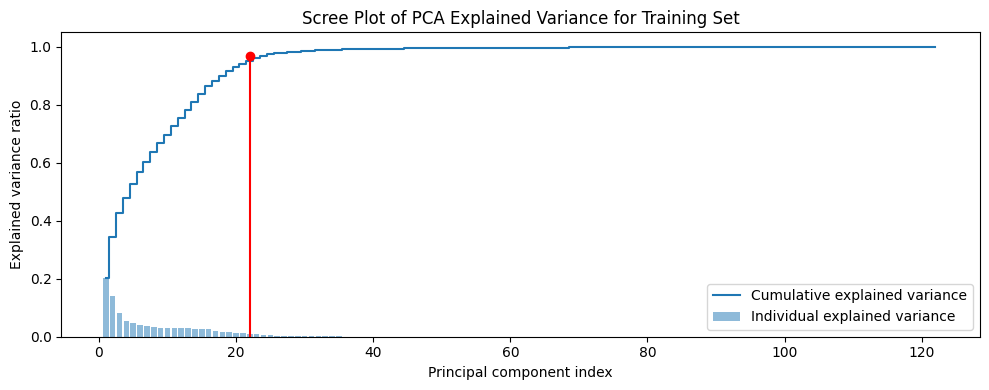

In [25]:
# For the training set
# Prepare feature variables for training set
X_train = df_train_scaled.drop(['outcome', 'level'], axis=1)

# Apply PCA to assess dimensionality reduction for the training set
pca_train = PCA()
pca_train.fit(X_train)

# Generate a scree plot for the training set to visualize explained variance ratio by each component
plt.figure(figsize=(10, 4))
explained_variance_ratio_train = pca_train.explained_variance_ratio_
cumulative_explained_variance_train = np.cumsum(explained_variance_ratio_train)
plt.bar(range(1, len(explained_variance_ratio_train) + 1), explained_variance_ratio_train, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_explained_variance_train) + 1), cumulative_explained_variance_train, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Scree Plot of PCA Explained Variance for Training Set')
plt.legend(loc='best')
plt.stem(22, 0.97, linefmt = 'red', label= 'Elbow')
plt.tight_layout()  # Adjust layout to fit everything
plt.show()


In [26]:
# Prepare feature and target variables from the training set
X_train = df_train_scaled.drop(['outcome', 'level'], axis=1)
y_train_classification = df_train_scaled['outcome'].astype(int)  # Direct conversion to int for classification
y_train_regression = df_train_scaled['level']  # For regression

# Apply PCA to reduce dimensionality for the classification task on the training data
pca = PCA(n_components=22)
X_train_reduced = pca.fit_transform(X_train)  # Fit PCA and reduce dimensionality of training data
print(f"Number of original features is {X_train.shape[1]} and of reduced features is {X_train_reduced.shape[1]}")

# Initialize a dictionary to store evaluation metrics
model_evals = {}

Number of original features is 122 and of reduced features is 22


In [27]:
# Assuming 'outcome' is the target variable you are predicting
# Extracting features and target from the scaled training data
X_train = df_train_scaled.drop('outcome', axis=1)
Y_train = df_train_scaled['outcome'].astype(int)  # assuming 'outcome' is already encoded as integer

# Extracting features and target from the scaled testing data
x_test = df_test_scaled.drop('outcome', axis=1)
y_test = df_test_scaled['outcome'].astype(int)  # assuming 'outcome' is already encoded as integer


In [28]:
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):

    # Fit the model using the training data
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_precision = precision_score(y_train, y_pred_train, average='macro')
    test_precision = precision_score(y_test, y_pred_test, average='macro')
    train_recall = recall_score(y_train, y_pred_train, average='macro')
    test_recall = recall_score(y_test, y_pred_test, average='macro')

    # Output metrics
    print(f"Training Accuracy {name}: {train_accuracy*100:.2f}%")
    print(f"Test Accuracy {name}: {test_accuracy*100:.2f}%")
    print(f"Training Precision {name}: {train_precision*100:.2f}%")
    print(f"Test Precision {name}: {test_precision*100:.2f}%")
    print(f"Training Recall {name}: {train_recall*100:.2f}%")
    print(f"Test Recall {name}: {test_recall*100:.2f}%")

    # Display confusion matrix
    confusion_mtx = confusion_matrix(y_test, y_pred_test)
    display_labels = ['Normal', 'Attack']
    cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=display_labels)
    fig, ax = plt.subplots(figsize=(10,10))
    cm_display.plot(ax=ax)
    plt.grid(False)
    plt.show()

# You will call the evaluate_classification function like this, for example:
# evaluate_classification(your_model, 'Your Model Name', X_train, X_test, y_train_class, y_test_class)


In [29]:
# Initialize Logistic Regression model with various parameters
lr = LogisticRegression(
    penalty='l2',                # Specifies the norm used in the penalization (regularization). 'l2' is the standard L2 regularization.
    tol=1e-4,                    # Tolerance for stopping criteria. This tells the model when to stop searching for a minimum (convergence).
    C=0.1,                       # Inverse regularization strength. Smaller values specify stronger regularization.
    fit_intercept=True,          # Specifies if a constant (bias or intercept) should be added to the decision function.
    class_weight=None,           # Weights associated with classes. If None, all classes are supposed to have weight one.
    random_state=None,           # The seed used by the random number generator (for shuffling the data).
    solver='newton-cg',                # Algorithm to use in the optimization problem. For small datasets, 'liblinear' is a good choice, whereas 'sag' and 'saga' are faster for large ones.
    max_iter=10000,              # Maximum number of iterations for the solvers to converge.
    n_jobs=8,                 # Number of CPU cores used when parallelizing. None means 1 unless in a joblib.parallel_backend context.
    l1_ratio=None                # The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1. l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.
)

# Fit the Logistic Regression model on the training dataset
# This step involves training the model using the training data
lr.fit(X_train, Y_train)

LogisticRegression(C=0.1, max_iter=10000, n_jobs=8, solver='newton-cg')

In [30]:
# Evaluate the fitted model's performance on both the training and testing datasets
# The 'evaluate_classification' function prints out several metrics and displays a confusion matrix
evaluate_classification(lr, "Logistic Regression", X_train, x_test, Y_train, y_test)

# Perform 5-fold cross-validation to assess model's stability and performance across different subsets of the data
# Cross-validation is crucial for verifying the model's ability to generalize to unseen data
cv_scores = cross_val_score(lr, X_train_reduced, Y_train, cv=5, scoring='accuracy')

# Print the accuracy scores obtained from cross-validation
# These scores provide insight into how the model performs on different folds of the training data
print("Cross-Validation Accuracy Scores:", cv_scores)

# Calculate the mean and standard deviation of the cross-validation scores to get an overall performance metric and its variability
mean_cv_accuracy = cv_scores.mean()
std_cv_accuracy = cv_scores.std()
print(f"Mean CV Accuracy: {mean_cv_accuracy:.2f}, Standard Deviation in CV Accuracy: {std_cv_accuracy:.2f}")


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- service_aol
- service_harvest
- service_http_2784
- service_http_8001
- service_red_i
- ...


In [ ]:
# Initialize the RandomForestClassifier with various parameters
rf = RandomForestClassifier(
    n_estimators=100,        # Number of trees in the forest.
    criterion='gini',        # The function to measure the quality of a split. 'gini' for Gini impurity and 'entropy' for information gain.
    max_depth=None,          # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    min_samples_split=2,     # The minimum number of samples required to split an internal node.
    min_samples_leaf=1,      # The minimum number of samples required to be at a leaf node.
    min_weight_fraction_leaf=0.0, # The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.
    max_leaf_nodes=None,     # Grow trees with `max_leaf_nodes` in best-first fashion. Best nodes are defined as relative reduction in impurity.
    min_impurity_decrease=0.0, # A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
    bootstrap=True,          # Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
    oob_score=False,         # Whether to use out-of-bag samples to estimate the generalization accuracy.
    n_jobs=-1,             # The number of jobs to run in parallel. None means 1. -1 means using all processors.
    random_state=None,       # Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node.
    verbose=0,               # Controls the verbosity when fitting and predicting.
    warm_start=False,        # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.
    class_weight=None,       # Weights associated with classes in the form `{class_label: weight}`. If not given, all classes are supposed to have weight one.
    ccp_alpha=0.0,           # Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than `ccp_alpha` will be chosen.
    max_samples=None         # If bootstrap is True, the number of samples to draw from X to train each base estimator.
)

# Fit the Random Forest classifier to the training data
rf.fit(X_train, y_train_class)

In [ ]:
# Evaluate the model's performance on both the training and test sets
evaluate_classification(rf, "RandomForestClassifier", X_train, X_test, y_train_class, y_test_class)

# Perform 5-fold cross-validation to assess model's stability and performance across different subsets of the data
# Cross-validation is crucial for verifying the model's ability to generalize to unseen data
cv_scores = cross_val_score(rf, X_train, y_train_class, cv=5, scoring='accuracy')

# Print the accuracy scores obtained from cross-validation
# These scores provide insight into how the model performs on different folds of the training data
print("Cross-Validation Accuracy Scores:", cv_scores)

# Calculate the mean and standard deviation of the cross-validation scores to get an overall performance metric and its variability
mean_cv_accuracy = cv_scores.mean()
std_cv_accuracy = cv_scores.std()
print(f"Mean CV Accuracy: {mean_cv_accuracy:.2f}, Standard Deviation in CV Accuracy: {std_cv_accuracy:.2f}")

In [ ]:
def f_importances(coef, names, top=-1):
    # coef: Array of feature importances (coefficients or importances from a model)
    # names: Array of feature names
    # top: Specifies the number of top features to display. Default is -1, which shows all features.

    # Zip together the importances and names, sort them by importance, and then unzip them back.
    imp, names = zip(*sorted(list(zip(coef, names))))

    # If top is -1 (default), show all features. Otherwise, show the specified number of top features.
    if top == -1:
        top = len(names)

    # Create a figure with a specified size for the plot
    plt.figure(figsize=(10,10))

    # Create a horizontal bar chart showing the feature importances.
    # imp[::-1][0:top] reverses the sorted importances to display the most important features at the top.
    plt.barh(range(top), imp[::-1][0:top], align='center')

    # Set the y-ticks to correspond to the features, displaying the most important feature at the top.
    plt.yticks(range(top), names[::-1][0:top])

    # Set the title of the plot
    plt.title('Feature Importances for Random Forest Decision Tree')

    # Display the plot
    plt.show()

# Extract feature names, excluding the target variables 'outcome' and 'level'
features_names = X_train.columns

In [ ]:
# Call the function f_importances to display the feature importances from the Random Forest model
# rf.feature_importances_ gives the importance of each feature in the Random Forest
# abs() is used to ensure all importances are positive, but it's typically unnecessary for Random Forest importances as they are always positive
f_importances(abs(rf.feature_importances_), features_names, top=18)